In [26]:
import scipy
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
data=pd.read_csv('./data/prostate.data',delimiter='\t',index_col=0)
data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


The correlation matrix of the predictors:

In [9]:
data.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652,0.734460
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354,0.433319
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460,0.179809
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648,0.566218
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528,0.548813
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000,0.422316
lpsa,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1.000000


**Scatterplot matrix:**(showing every pairwise plot between the variables)We see that *svi* is a binary variable, and *gleason* is an ordered categorical variable. 

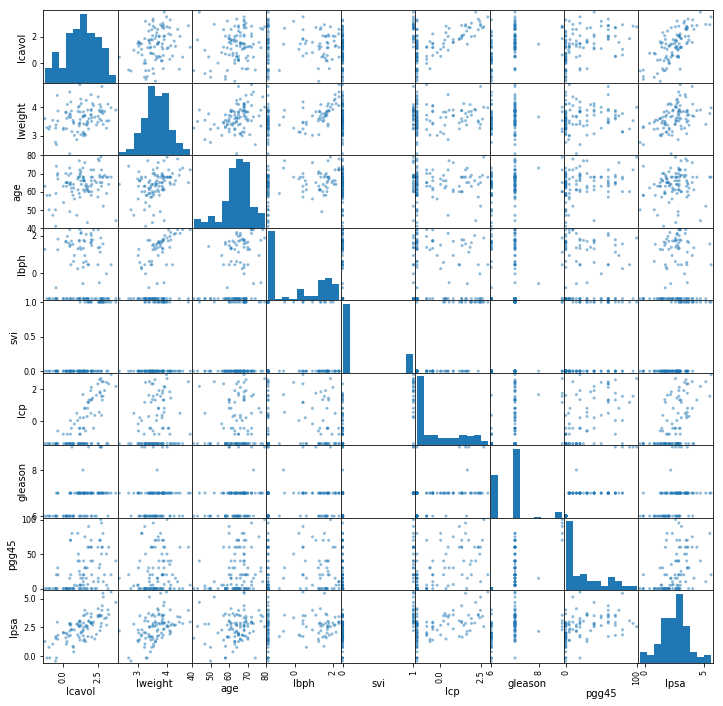

In [15]:
pd.plotting.scatter_matrix(data,figsize=(12,12))
plt.show()

## Simple univariate regression

In [103]:
y=data['lpsa']
mask_train=data['train']
X=data.drop(['lpsa','train'],axis=1)


def get_train_data(X):
    #normalize X
    X=X.apply(scipy.stats.zscore)
    X_train=X[mask_train=='T']
    y_train=y[mask_train=='T']
    X_test=X[mask_train!='T']
    y_test=y[mask_train!='T']
    X_test=np.hstack((np.ones((len(X_test),1)),X_test))
    X_train=np.hstack((np.ones((len(X_train),1)),X_train))
    return X_train, y_train,X_test,y_test

X_train, y_train,X_test,y_test=get_train_data(X)
X_train.shape

(67, 9)

\begin{align}\hat{\beta}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty \end{align}
Fitted values at the training inputs: $\hat{y}=\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty$

In [161]:
def ols(X_,y_):
    w=np.linalg.inv(X_.T.dot(X_)).dot(X_.T).dot(y_)
    y_hat=X_.dot(w)
    return w,y_hat
w,y_hat=ols(X_train,y_train)
y_hat.shape

(67,)

Unbiased estimate of $\sigma^2$: 
\begin{align} \hat{\sigma^2}=\frac{1}{N-p-1}\sum^{N}_{i=1}(y_i-\hat{y_i})^2 \end{align}

In [62]:
sigma2_hat=sum((y_train-y_hat)**2)/(len(y_train)-1-len(X.columns))
sigma2_hat

0.5073514562053173

The variance–covariance matrix of the least squares parameter estimates: 
\begin{align} Var(\hat{\beta})=(\mathbf{X}^T\mathbf{X})^{-1}\sigma^2) \end{align}

In [66]:
std_w=np.sqrt(np.diag(np.linalg.inv(X_train.T.dot(X_train)))*sigma2_hat)
std_w

array([ 0.08931498,  0.12597461,  0.095134  ,  0.10081871,  0.10169077,
        0.1229615 ,  0.15373073,  0.14449659,  0.1528197 ])

In [73]:
table=pd.DataFrame(columns=['Term','Coeﬃcient','Std. Error','Z Score'])
table['Term']=['Intercept']+list(X.columns)
table['Coeﬃcient']=w
table['Std. Error']=std_w
table['Z Score']=w/std_w
table

,Term,Coeﬃcient,Std. Error,Z Score
0,Intercept,2.464933,0.089315,27.598203
1,lcavol,0.676016,0.125975,5.366290
2,lweight,0.261694,0.095134,2.750789
3,age,-0.140734,0.100819,-1.395909
4,lbph,0.209061,0.101691,2.055846
5,svi,0.303623,0.122962,2.469255
6,lcp,-0.287002,0.153731,-1.866913
7,gleason,-0.021195,0.144497,-0.146681
8,pgg45,0.265576,0.152820,1.737840


We can also test for the exclusion of a number of terms at once, using the F-statistic:
\begin{align} F=\frac{(RSS_2-RSS_1)/(p_1-p_2)}{RSS_1/(N-p_1)} \end{align}
\begin{align}
RSS(\beta)=\sum_{i=1}^{N}(y_{i}-f(x_{i}))^2=\sum_{i=1}^{N}(y_{i}-\beta_{0}-\sum_{j=1}^{p}X_{ij}\beta_{j})^2
\end{align}

we consider dropping all the non-signiﬁcant terms, namely *age, lcp, gleason, and pgg45*

In [102]:
X2=X.drop(['age', 'lcp', 'gleason', 'pgg45'],axis=1)
X_train2, y_train2,X_test2,y_test2=get_train_data(X2)
w2,y_hat2=ols(X_train2,y_train2)
RSS1=sum((y_train-y_hat)**2)
RSS2=sum((y_train2-y_hat2)**2)

p2=X_train2.shape[1]
N,p1=X_train.shape
F=round(((RSS2-RSS1)/(p1-p2))/((RSS1)/(N-p1)),2)
p_value=round(1-scipy.stats.f.cdf(F,p1-p2,N-p1),2)

print("F:{}".format(F))
print("Pr(F({a},{b})>{c})={d}".format(a=p1-p2,b=N-p1,c=F,d=p_value))

F:1.67
Pr(F(4,58)>1.67)=0.17


In [167]:
RSS1,RSS2

(29.4263844599084, 32.81499474881556)

The mean prediction error on the test data is 0.521. In contrast, prediction using the mean training value of lpsa has a test error of 1.057, which is called the “base error rate.” Hence the linear model reduces the base error rate by about 50%. We will return to this example later to compare various selection and shrinkage methods.

In [117]:
y_test_fit=X_test.dot(w)
base_error=round(sum((y_test-y_train.mean())**2)/len(y_test),3)
prediction_error=round(sum((y_test-y_test_fit)**2)/len(y_test),3)
print('base_error:',base_error)
print('prediction_error:',prediction_error)

base_error: 1.057
prediction_error: 0.521


## Best-Subset Selection

In [125]:
import math
import itertools

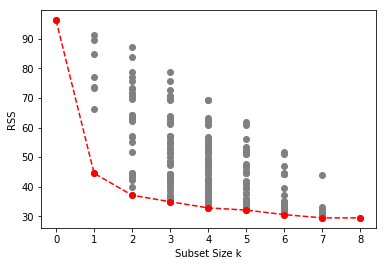

In [177]:

def nCr(n,r):
    """calculate how many combination of (n,r)"""
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

def best_subset_ols(i):
    """calculate all ols estimate of i size subset"""
    combine=itertools.combinations(range(1,p+1),i)
    y_subset_train=y_train
    result=[]
    for k in combine:
        X_subset_train=X_train[:,[0]+list(k)]
        w,y_hat=ols(X_subset_train,y_subset_train)
        result.append((w,sum((y_subset_train-y_hat)**2)))
    return np.array(result)


p=len(X.columns)
best=[]
for i in range(0, p+1):
    ncr=nCr(p,i)
    result=best_subset_ols(i)
    best.append(min(result[:,1]))
    plt.plot(np.ones(ncr)*i,result[:,1],'o',c='grey')
plt.plot(range(0, p+1),best,'o--',c='red')  
plt.xlabel('Subset Size k')
plt.ylabel('RSS')
plt.savefig('./images/best_subset.png')

## The ridge regression

In [212]:
U,D,V=np.linalg.svd(X_train, full_matrices=False)
p=len(D)


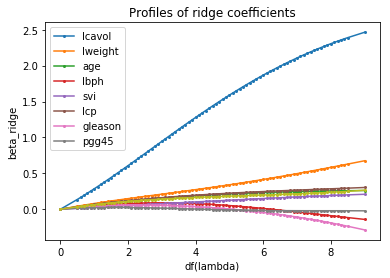

In [221]:
def df(D,lam):
    return sum(D**2/(D**2+lam))

def ddf(D,lam):
    return -sum(D**2/(D**2+lam)**2)

def newton(p,D):
    """Calculate lambdas through eﬀective degrees of freedom """
    edfs=np.linspace(0.5, p-0.5, (p-1)*10+1)
    threshold=1e-3
    lambdas=[]
    for i in edfs:
        lam0=(p-i)/i
        lam1=1e6
        diff=lam1-lam0
        while diff>threshold:
            lam1=lam0-(df(D,lam0)-i)/ddf(D,lam0)
            diff=lam1-lam0
            lam0=lam1
            
        lambdas.append(lam1)
    lambdas.append(0)
    edfs=np.concatenate(([0],edfs,[p]))
    return edfs,np.array(lambdas)

edfs,lambdas=newton(p,D)
beta_ridge=[np.zeros(p)]
for lam in lambdas:
    beta=V.T.dot(np.diag(D/(D**2+lam))).dot(U.T).dot(y_train)
    beta_ridge.append(beta)
beta_ridge=np.array(beta_ridge)
plt.plot(edfs,beta_ridge, 'o-', markersize=2)
plt.xlabel('df(lambda)')
plt.ylabel('beta_ridge')
plt.legend(X.columns)
plt.title('Proﬁles of ridge coeﬃcients')
plt.show()